In [1]:
import numpy as np
import pyccl as ccl
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import pyccl.nl_pt as pt

import sys
sys.path.append('../code/bispectrum/')

import bihalofit
import importlib
importlib.reload(bihalofit)
import bispectrum
importlib.reload(bispectrum)

import fsb
importlib.reload(fsb)

import time

In [2]:
matplotlib.rcParams['lines.linewidth'] = 1.5
matplotlib.rcParams['lines.linestyle'] = '-'  
matplotlib.rcParams['lines.color'] = 'black'

matplotlib.rcParams['patch.linewidth'] = 1.5
 
#fonts & text
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.weight'] = 'normal'
matplotlib.rcParams['font.size'] = 12.0
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['text.usetex'] = True
 
#axes & ticks
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = 1.  
matplotlib.rcParams['axes.grid'] = False
matplotlib.rcParams['axes.titlesize'] = 'x-large'
matplotlib.rcParams['axes.labelsize'] = 'x-large'
matplotlib.rcParams['axes.labelweight'] = 'normal'
matplotlib.rcParams['axes.labelcolor'] = 'black'
matplotlib.rcParams['axes.formatter.limits'] = [-4, 4]
 
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['xtick.minor.size'] = 4
matplotlib.rcParams['xtick.major.pad'] = 6
matplotlib.rcParams['xtick.minor.pad'] = 6
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['xtick.minor.width'] = 1.0
matplotlib.rcParams['xtick.major.width'] = 1.0
 
matplotlib.rcParams['ytick.major.size'] = 7
matplotlib.rcParams['ytick.minor.size'] = 4
matplotlib.rcParams['ytick.major.pad'] = 6
matplotlib.rcParams['ytick.minor.pad'] = 6
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.minor.width'] = 1.0
matplotlib.rcParams['ytick.major.width'] = 1.0
 
#legends
matplotlib.rcParams['legend.numpoints'] = 1
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['legend.shadow'] = False
matplotlib.rcParams['legend.frameon'] = False

matplotlib.rcParams['figure.autolayout'] = True


In [3]:
colors = ['#e3a19c', '#85a1ca', '#596d82', '#725e9c', '#3d306b', '#AE7182']

Read FSB power spectra from Lea and David.

In [4]:
def read_fsb(fname):
    hdulist = fits.open(fname)
    d = hdulist[1].data
    print(d.columns)
    ls = d['ells'].reshape((-1, 45))

    temp = d['fsb'].reshape((-1, 45))
    fsb = temp[:-1, :]
    cls = temp[-1, :]
    efsb = d['err_np'].reshape((-1, 45))
    
#     print(efsb[0, :])
#     efsb = d['err_sims'].reshape((-1, 45))
#     print(efsb[0, :])

    return {'ells': ls, 'fsb': fsb, 'efsb': efsb, 'cls': cls}

dln_test = read_fsb("../data/GLAM_largesky_nbands5_lpb17_noweights.fits")

ColDefs(
    name = 'ells'; format = 'D'
    name = 'fsb'; format = 'D'
    name = 'err_nmt'; format = 'D'
    name = 'err_np'; format = 'D'
)


In [5]:
def read_fsb(fname):
    d = np.load(fname)
    Ls = d['Ls']
    ls = d['ls']
    
    print(d['fsbs'].shape)
    fsb = np.mean(d['fsbs'], axis=0)
    efsb = np.std(d['fsbs'], axis=0)
    cl = np.mean(d['cls'], axis=0)
    ecl = np.std(d['cls'], axis=0)
    return {'Ls': Ls, 'ls': ls, 'fsb': fsb, 'efsb': efsb, 'cl': cl, 'ecl': ecl}

dln = read_fsb("fsb_largesky_nmt_submean.npz")

(630, 8, 47)


Text(0, 0.5, '$C_\\ell$')

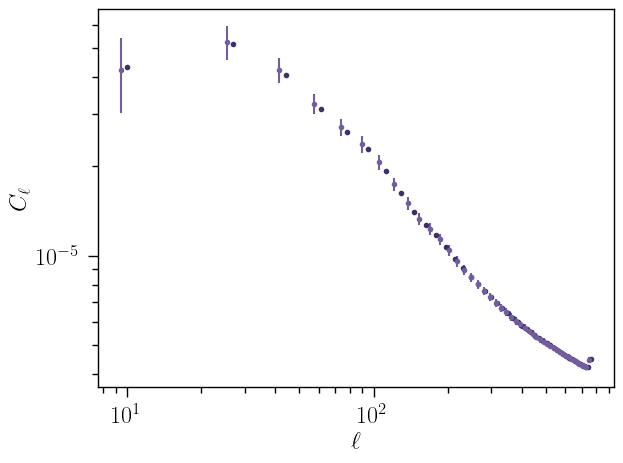

In [6]:
plt.errorbar(dln['ls'], dln['cl'], yerr=dln['ecl'], marker='.', linestyle='None', color=colors[3])
plt.loglog(dln_test['ells'][0, :], dln_test['cls'], marker='.', linestyle='None', color=colors[4])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

In [7]:
cosmo = ccl.Cosmology(Omega_c = 0.27, Omega_b = 0.045, h = 0.67, sigma8 = 0.81, n_s = 0.96)

Read $n(z)$ for CMASS, also from David.

In [8]:
nzdata = np.load('../data/nz_andrina.npz')

/users/anicola/anaconda3/envs/bisp_env_py11/lib/python3.11/site-packages/pyccl/tracers.py:151: CCLWarning: The number of samples in the n(z) (100) is smaller than the number of samples in the lensing kernel (256). Consider disabling spline integration for the lensing kernel by setting pyccl.gsl_params.LENSING_KERNEL_SPLINE_INTEGRATION = False before instantiating the Cosmology passed.
  warnings.warn(


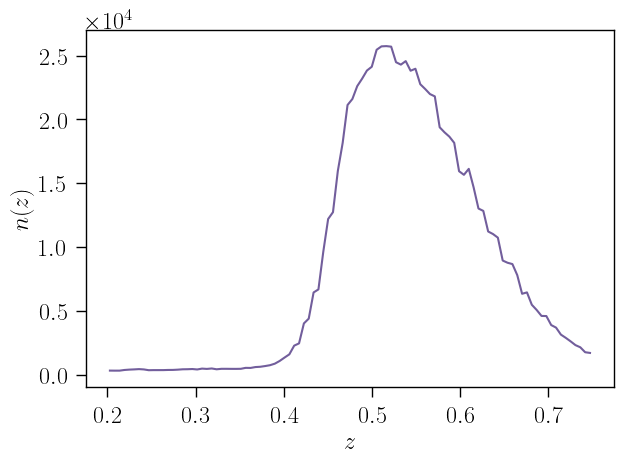

In [9]:
z = 0.5*(nzdata['z_lo']+nzdata['z_hi'])
# z = nzdata['z']
nz = nzdata['nz']

# BOSS
nbar = 303556
# nbar = nzdata['gal_per_srad']

plt.plot(z, nz, color=colors[3])
plt.xlabel(r'$z$')
plt.ylabel(r'$n(z)$')

trk = ccl.CMBLensingTracer(cosmo, z_source=1030) #CCL automatically normalizes dNdz

trl = ccl.WeakLensingTracer(cosmo, dndz=(z, nz)) #CCL automatically normalizes dNdz
trg = ccl.NumberCountsTracer(cosmo, dndz=(z, nz), has_rsd=False,bias=(z, np.ones_like(z))) #CCL automatically normalizes dNdz

In [10]:
ells = np.arange(1000)

cls = ccl.angular_cl(cosmo=cosmo, tracer1=trg, tracer2=trg, ell=ells)

Text(0, 0.5, '$C_\\ell$')

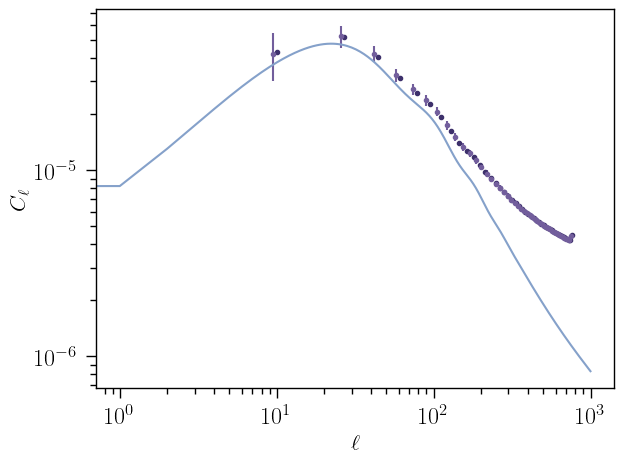

In [11]:
plt.figure()
plt.errorbar(dln['ls'], dln['cl'], yerr=dln['ecl'], marker='.', linestyle='None', color=colors[3])
plt.loglog(dln_test['ells'][0, :], dln_test['cls'], marker='.', linestyle='None', color=colors[4])
plt.plot(ells, 2**2*cls, color=colors[1])
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)

In [12]:
# Matter
ptt_m = pt.PTMatterTracer()

# Biases for number counts 
b_1 = 2.0 # constant values for now
# b_2 = 1.0
# b_s = 1.0

# Number counts
# ptt_g = pt.PTNumberCountsTracer(b1=b_1, b2=b_2, bs=b_s)
ptt_g = pt.PTNumberCountsTracer(b1=b_1)

## FSB

In [13]:
def get_bands(nbands, nside):
    nell = (3*nside-1) - 2 # namaster starting at l=2
    dell = nell//nbands
    fls = np.zeros([nbands, nell])
    for i in range(nbands):
        fls[i, i*dell:(i+1)*dell] = 1.0
    return fls

mask = get_bands(5, 256).astype('bool')
ells = np.arange(2, 767)
for i in range(mask.shape[0]):
    print(ells[mask[i,:]])

[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154]
[155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 

In [14]:
ls_binarr = np.linspace(2, 767, 6, dtype='int')
ll_bins = np.linspace(2, 767, 46, dtype='int')

nbin_ls = ls_binarr.shape[0]-1
nbin_ll = ll_bins.shape[0]-1

Bk_fsb_intp = np.zeros((nbin_ls, nbin_ll))
Bk_fsb_hlft_intp = np.zeros((nbin_ls, nbin_ll))

myfsb = fsb.FSB()

for i in range(len(ls_binarr)-1):
    ls_bins = ls_binarr[i:i+2]
    print('ls bins = ', ls_bins)
    Bk_fsb_temp, Bl = myfsb.Bk_fsb_interp(cosmo, trg, trg, trk, ptt_g, ptt_g, ptt_m, ls_bins, ll_bins, \
                                          Bkm='tree', nbar=nbar)
    Bk_fsb_intp[i, :] = Bk_fsb_temp
    
myfsb = fsb.FSB()

for i in range(len(ls_binarr)-1):
    ls_bins = ls_binarr[i:i+2]
    print('ls bins = ', ls_bins)
    Bk_fsb_hlft_temp, Bl_hlft = myfsb.Bk_fsb_interp(cosmo, trg, trg, trk, ptt_g, ptt_g, ptt_m, \
                                                 ls_bins, ll_bins, Bkm='halofit', nbar=nbar)
    Bk_fsb_hlft_intp[i, :] = Bk_fsb_hlft_temp

ls bins =  [  2 155]
INFO:bispectrum:Computing Bggm
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [155 308]
ls bins =  [308 461]
ls bins =  [461 614]
ls bins =  [614 767]
ls bins =  [  2 155]
INFO:bispectrum:Computing Bggm
INFO:bispectrum:Assuming linear bias for the galaxy tracer.
ls bins =  [155 308]
ls bins =  [308 461]
ls bins =  [461 614]
ls bins =  [614 767]


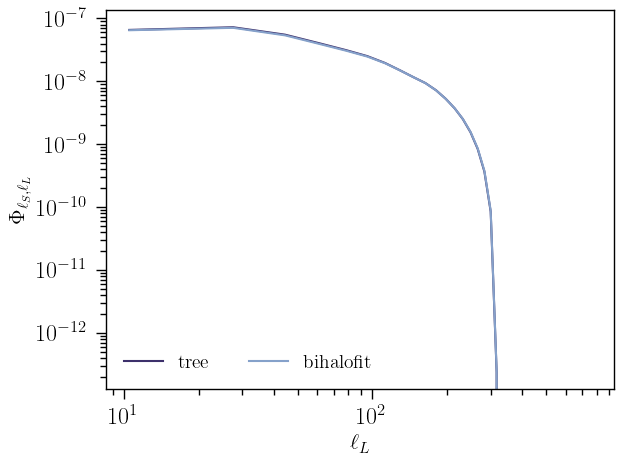

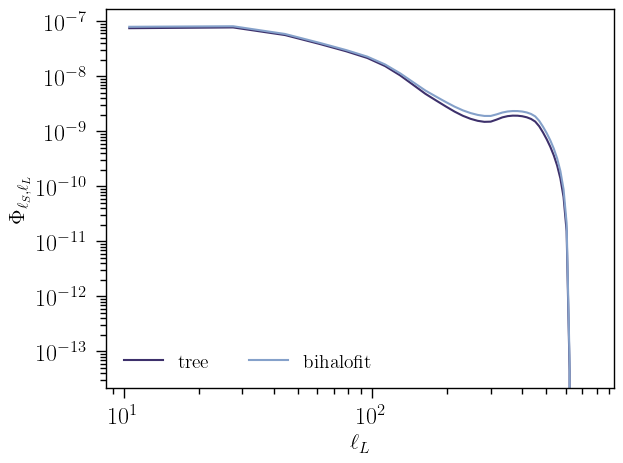

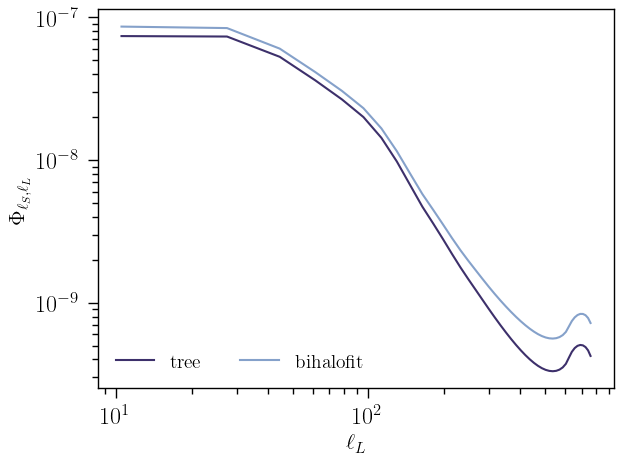

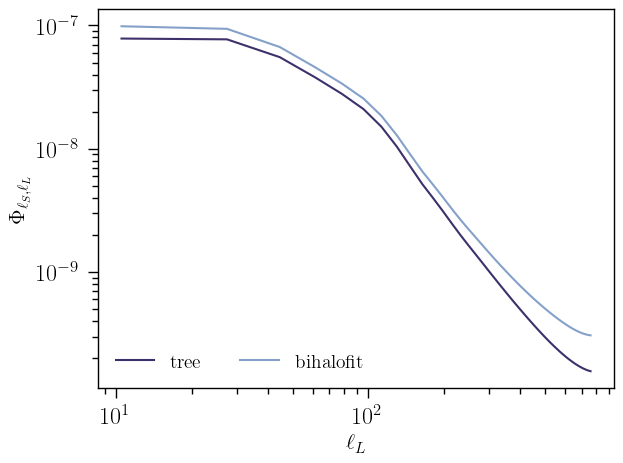

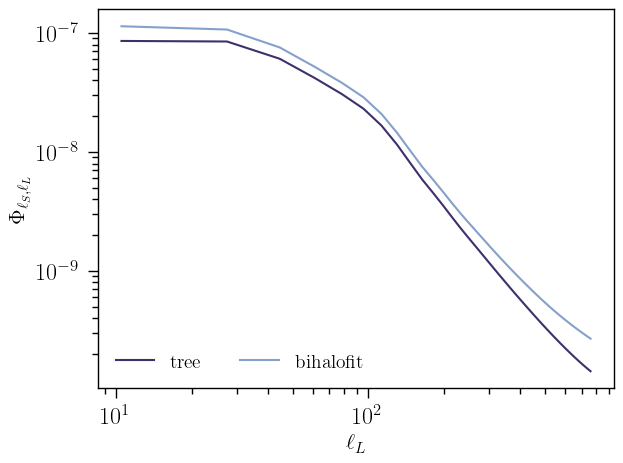

In [15]:
ll_means = 0.5*(ll_bins[:-1]+ll_bins[1:])

ls_bin_means = 0.5*(ls_binarr[:-1]+ls_binarr[1:])

for i in range(ls_bin_means.shape[0]):
    plt.figure()
#     plt.errorbar(dln_test['ells'][i, :], dln_test['fsb'][i], yerr=dln_test['efsb'][i], fmt='.', label=f'$\\ell_S=%d$' % (int(ls_bin_means[i])), color=colors[3])
    plt.loglog(ll_means, Bk_fsb_intp[i, :], label=r'$\mathrm{tree}$', color=colors[4])
    plt.loglog(ll_means, Bk_fsb_hlft_intp[i, :], label=r'$\mathrm{bihalofit}$', color=colors[1])
    plt.xlabel('$\\ell_L$', fontsize=16)
    plt.ylabel('$\\Phi_{\\ell_S,\\ell_L}$', fontsize=16)
    plt.legend(loc='lower left', fontsize=14, frameon=False, ncol=2)